In [1]:
from __future__ import division, print_function

import sys
import time
from collections import OrderedDict

import numpy as np

from scipy import interpolate, special

from astropy import units as u
from astropy.io import fits

from astropy.stats import sigma_clip

# Note: astropy v1.1 or greater needed here
from astropy.modeling import models, fitting
from astropy import visualization
from astropy.visualization import hist as ahist
from astropy.utils.console import ProgressBar

In [2]:
import emceemr
from emceemr import priors

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'viridis'

alllogstretch = visualization.LogStretch() + visualization.MinMaxInterval()
stretch99 = visualization.PercentileInterval(99) + visualization.LogStretch()
stretch95 = visualization.PercentileInterval(95) + visualization.LogStretch()

In [4]:
TWOPI = 2*np.pi
class SersicModel(emceemr.Model):
    param_names = 'flux, n, reffmaj, ellipticity, cenx, ceny, theta'.split(', ')
    def __init__(self, xg, yg, dat, ivar, priors):
        self.xg = xg
        self.yg = yg
        self.dat = dat
        self.ivar = ivar
        self.infiniteivar = ~np.isfinite(self.ivar)
        
        super(SersicModel, self).__init__(priors)
    
    def lnprob(self, flux, n, reffmaj, ellipticity, cenx, ceny, theta):
        mod = self.get_model(flux, n, reffmaj, ellipticity, cenx, ceny, theta)
        ddat = self.dat-mod
        res = -0.5*(self.ivar*ddat*ddat)#+ np.log(TWOPI*self.ivar))  #just a constant
        res[self.infiniteivar] = 0
        return res
    
    def get_model(self, flux, n, reffmaj, ellipticity, cenx, ceny, theta):
        dx = self.xg - cenx
        dy = self.yg - ceny
        if theta != 0:
            thrad = np.radians(theta)
            rotmat = [[np.cos(thrad), -np.sin(thrad)],
                      [np.sin(thrad), np.cos(thrad)]]
            dxy = np.array([dx, dy], copy=False)
            dx, dy = np.dot(rotmat, dxy.reshape(2,-1)).reshape(dxy.shape)
            
        reffmin = reffmaj*(1 - ellipticity)
        #rreff = np.hypot(dx/reffmin, dy/reffmaj)
        dx = dx/reffmin
        dy = dy/reffmaj
        rreff = np.sqrt(dx*dx + dy*dy)
        
        bn = self.bn(n)
        ebn = np.exp(bn)
        # normalize to make the integral over the areal profile to infinity = 1
        N = bn**(2*n)/ (TWOPI*reffmaj*reffmin * n * special.gamma(2*n)) 
        return flux * N * np.exp(-bn*rreff**(1/n))
    
        #more expressive way:
        #N = TWOPI*reffmaj*reffmin * n * special.gamma(2*n) * ebn * bn**(-2*n)
        #return flux * np.exp(-bn*(rreff**(1/n)-1)) / N
    
    @staticmethod
    def bn(n):
        return special.gammaincinv(2*n, 0.5)

In [5]:
from astropy.modeling.core import Fittable2DModel, Parameter

class PSFModel(Fittable2DModel):
    x_0 = Parameter('x_0', default=0)
    y_0 = Parameter('y_0', default=0)
    flux = Parameter('flux', default=1)
    
    def __init__(self, psfdat, psfcen=None, bbox_padding=None, **kwargs):
        if psfcen is None:
            psfcen = psfdat.shape[0]//2,psfdat.shape[1]//2
        self.psfcen = psfcen
        
        self.bbox_padding = bbox_padding
        
        x = np.arange(psfdat.shape[0])
        y = np.arange(psfdat.shape[1])
        self.spl = interpolate.RectBivariateSpline(x, y, psfdat)
        self.psfdat = psfdat
        
        kwargs.setdefault('x_0', psfcen[0])
        kwargs.setdefault('y_0', psfcen[1])
        
        super(PSFModel, self).__init__(**kwargs)
    
    def evaluate(self, x, y, x_0, y_0, flux):
        return flux * self.spl(x - x_0 + self.psfcen[0], 
                               y - y_0 + self.psfcen[1], 
                               grid=False)

    @property
    def bounding_box(self):
        bbox_padding = 0 if self.bbox_padding is None else self.bbox_padding
        hside_len = [side/2 - bbox_padding for side in self.psfdat.shape]
        return ((self.y_0 - hside_len[1], self.y_0 + hside_len[1]),
                (self.x_0 - hside_len[0], self.x_0 + hside_len[0]))

In [6]:
def sample_from_model(mod, npoints, verbose=False):
    """
    Assumes the model has a bounding_box to get where the points should live, and that the model value spans the 0-1 range.
    """
    bbox = np.array(mod.bounding_box)
    ntosample = 2*npoints
    acceptedcoords = []
    i = 0
    while ntosample>npoints:
        i += 1
        if verbose:
            print("On iter", i, 'with', ntosample - npoints, 'points left')
        coords = np.random.rand(mod.n_inputs, ntosample) * bbox[::-1,1:] + bbox[::-1,:-1]
        randval = np.random.rand(ntosample)
        modval = mod(*coords)
        
        accepted = modval>randval
        acceptedcoords.append(coords[..., accepted])
        ntosample = ntosample - np.sum(accepted)
    res = np.concatenate(acceptedcoords, axis=-1)
    if verbose:
        print("Ended up with", res.shape[-1], 'Need to trim to', npoints)
    return res[...,:npoints]

In [7]:
def sample_lum_func(n, alpha, tip, bottom):
    """
    A simple power law luminosity function 
    
    not that this should *not* necessarily be the same as the RGB power law, 
    as it's a superposition of multiple pops, and also different band (see below for source of 1.2 from piscA)
    """
    m1, m2 = tip, bottom
    P = np.random.rand(n)
    paren = np.exp(alpha*m2) - np.exp(alpha*m1)
    F = P*paren + np.exp(alpha*m1)
    return np.log(F)/alpha

# First we characterize the pisc *A* dataset (higher res) to get the LF and noise ~ right 

## Start with the Luminosity function  

In [7]:
d = np.loadtxt('PiscA_dolphot/piscA')

#object is roughly here
x0 = 3650
y0 = 5400

# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15]
sn606 = ds[:, 19]

m814 = ds[:,28]
sn814 = ds[:, 32]

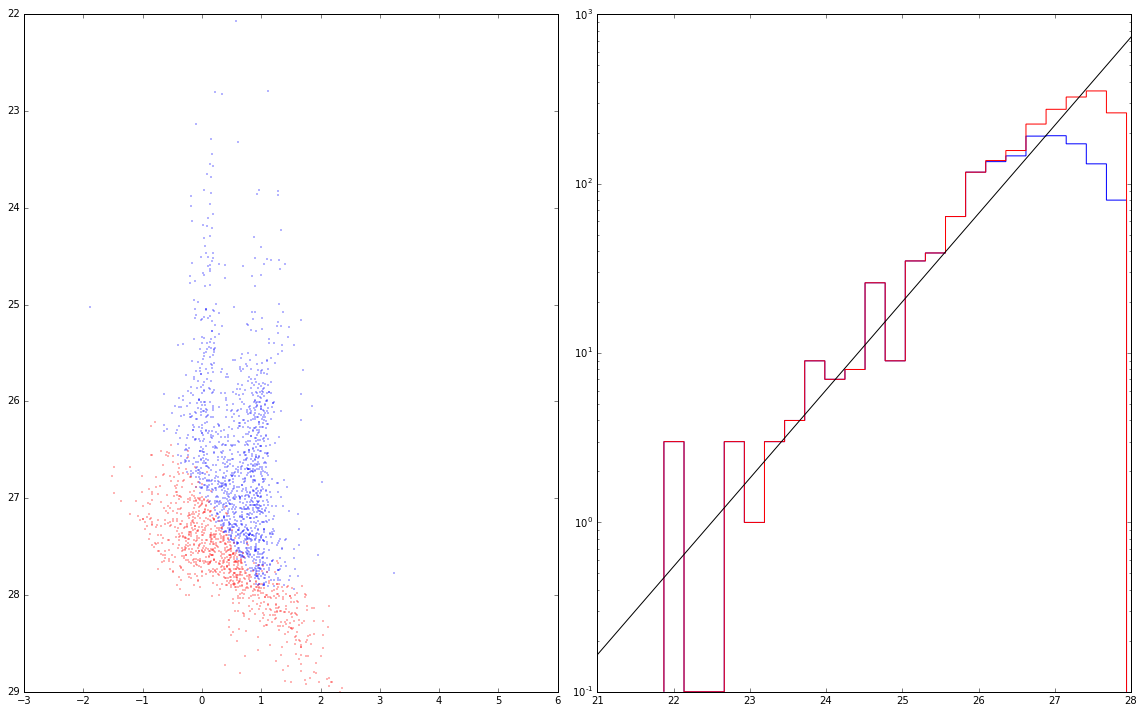

In [240]:
dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])

msk_dwarf = dpx_dwarf < 500
sncut4 = (sn606>4)&(sn814>4)
sncut1 = (sn606>1)&(sn814>1)

msk1 = msk_dwarf&sncut4
msk2 = msk_dwarf&sncut1&~sncut4

plt.subplot(1,2,1)
plt.scatter((m606-m814)[msk1], m606[msk1],lw=0,s=3,alpha=.5)
plt.scatter((m606-m814)[msk2], m606[msk2],lw=0,s=3,alpha=.5, c='r')

plt.ylim(29,22)

plt.subplot(1,2,2)
# we are adding one to mock up piscB
bins = ahist(m606[msk_dwarf&sncut4], bins='knuth',histtype='step', color='b', log=True)[1]
ahist(m606[msk_dwarf&sncut1], bins=bins,histtype='step', color='r', log=True)

#plot a trial power law to the pre roll-over
x1, x2 = plt.xlim()
xs = np.linspace(x1, x2, 100)

plt.plot(xs, np.exp(1.2*(xs-22.5)), c='k')

plt.xlim(x1, x2)


plt.tight_layout()

So we want a slope of ~1.2, with ~1 in the piscB equivalent of F606W = 22

## Now figure out the Pisc B image's noise characteristics 

In [16]:
def read_data(objnm, filtnm, suffix='_err'):
    fntempl = 'drizzled_{objnm}_{filtnm}{suffix}/{objnm}_{filtnm}{suffix}_drc_{ftype}.fits'
    
    ftype = '<whatever>'
    print('Loading data from', fntempl.format(**locals()))
    
    ftype = 'sci'
    fn = fntempl.format(**locals())
    scif = fits.open(fn)
    tab = scif[1]
    sciim = scif[0]
    sciim.header['FILENAME'] = fn
    ftype = 'wht'
    fn = fntempl.format(**locals())
    whtim = fits.open(fn)[0]
    whtim.header['FILENAME'] = fn
    ftype = 'ctx'
    fn = fntempl.format(**locals())
    ctxim = fits.open(fn)[0]
    ctxim.header['FILENAME'] = fn
    
    return sciim, whtim, ctxim, tab

# for PiscB from Structural Parameters notebook
centerB = [5870, 4285]
mskB = (slice(centerB[0]-340, centerB[0]+340), 
       slice(centerB[1]-440, centerB[1]+420))

f606w_b_sci, f606w_b_wht, f606w_b_ctx, f606w_b_tab = read_data('PiscB', 'F606W')

pisc_b_real_sci_all = f606w_b_sci.data
pisc_b_real_wht_all = f606w_b_wht.data

pisc_b_real_sci_near = pisc_b_real_sci_all[mskB]
pisc_b_real_wht_near = pisc_b_real_wht_all[mskB]

center_bkg = [4800, 800] # a reasonable chunk of mostly background still near and on WFC1
msk_bkg = (slice(center_bkg[0]-340, center_bkg[0]+340), 
           slice(center_bkg[1]-440, center_bkg[1]+420))
pisc_b_real_sci_bkg = pisc_b_real_sci_all[msk_bkg]
pisc_b_real_wht_bkg = pisc_b_real_wht_all[msk_bkg]

Loading data from drizzled_PiscB_F606W_err/PiscB_F606W_err_drc_<whatever>.fits


(-11.026003, 5637.3237, 0.0096397464611298733)

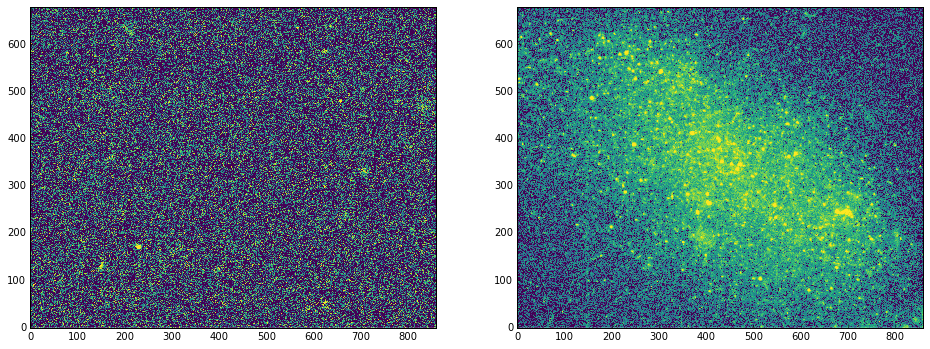

In [17]:
plt.subplot(1,2,1)
plt.imshow(stretch99(pisc_b_real_sci_bkg))

plt.subplot(1,2,2)
plt.imshow(stretch99(pisc_b_real_sci_near))

np.sum(pisc_b_real_sci_bkg), np.sum(pisc_b_real_sci_near), np.sum(pisc_b_real_sci_near)/pisc_b_real_sci_near.size

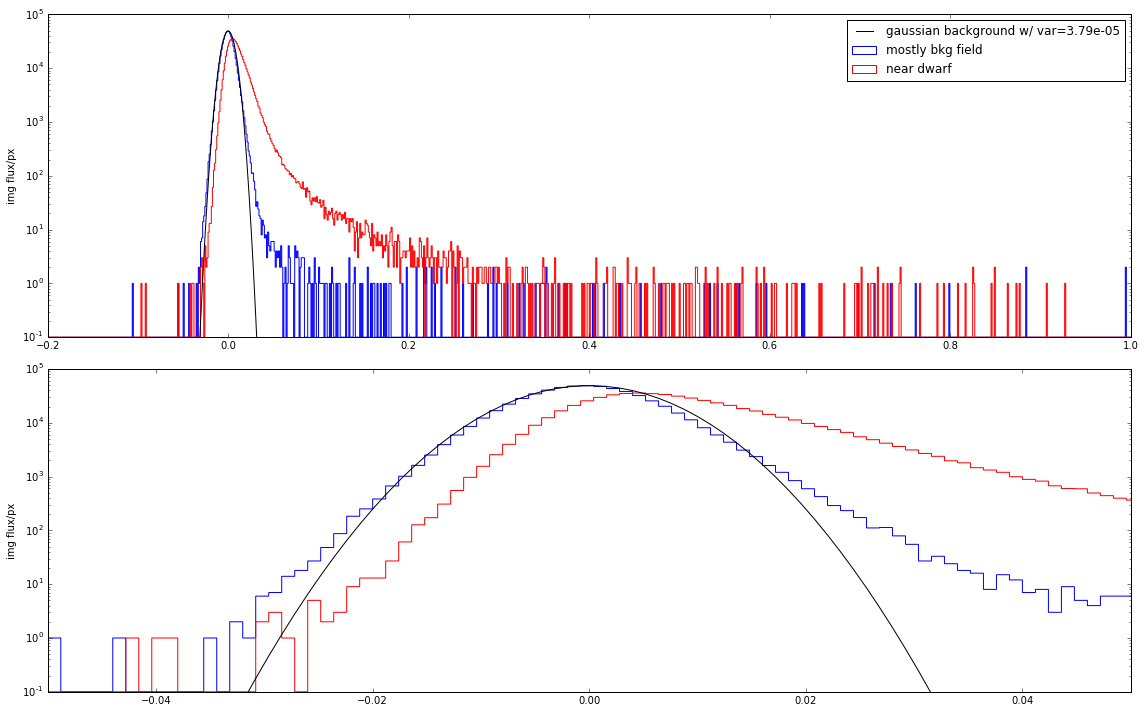

In [353]:
pisc_b_real_sci_bkg_clipped = sigma_clip(pisc_b_real_sci_bkg, sigma=5)
bkg_var = np.var(pisc_b_real_sci_bkg_clipped)

def plots():
    bins = 1000
    hkwargs = dict(histtype='step', log=True, range=(-.2, 1))
    ns, bins = ahist(pisc_b_real_sci_bkg.ravel(), color='b', bins=bins, label='mostly bkg field', **hkwargs)[:2]
    ahist(pisc_b_real_sci_near.ravel(), color='r',bins=bins, label='near dwarf', **hkwargs)
    yls = plt.ylim()
    plt.plot(bins, np.max(ns)*np.exp(-0.5*bins**2/bkg_var), color='k', label='gaussian background w/ var={:.3}'.format(bkg_var))
    plt.ylim(*yls)
    plt.ylabel('img flux/px')

plt.subplot(2,1,1)
plots()
plt.legend(loc=0)

plt.subplot(2,1,2)
plots()
plt.xlim(-.05,.05)

plt.tight_layout()

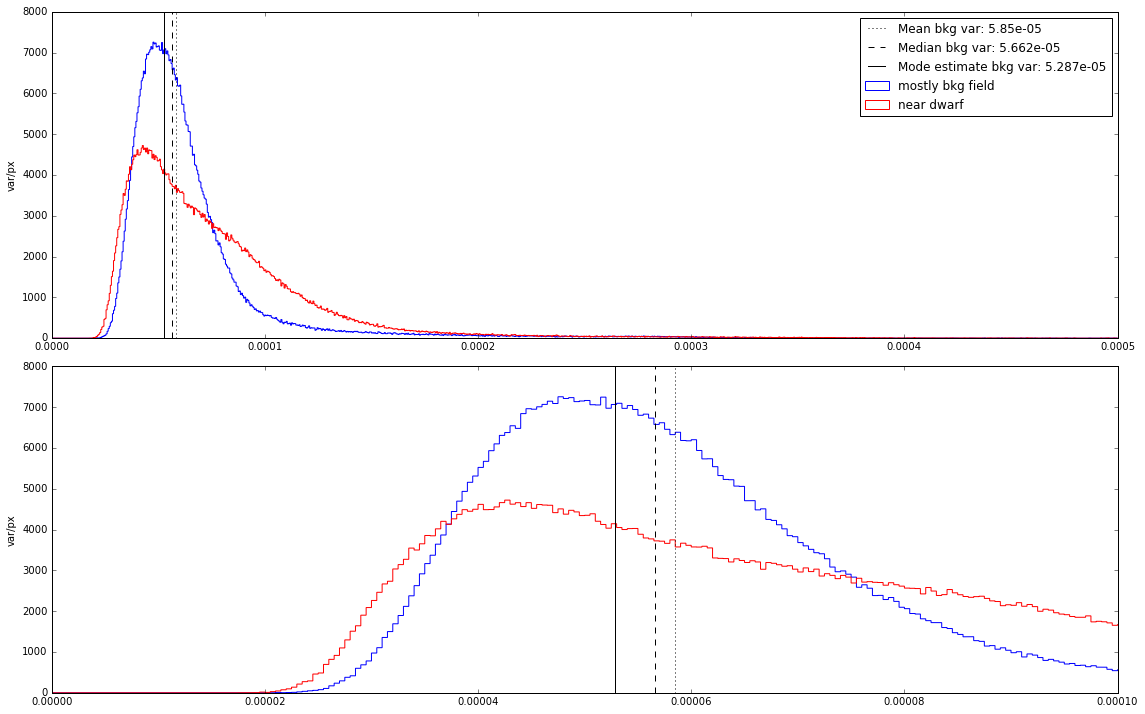

In [354]:
def mskdat(dat):
    msk = dat>0
    return dat[msk]

def plots():
    bins = 1000
    hkwargs = dict(histtype='step', log=False, range=(0,0.0005))
    ns, bins = ahist(1.0/mskdat(pisc_b_real_wht_bkg), color='b', bins=bins, label='mostly bkg field', **hkwargs)[:2]
    ahist(1.0/mskdat(pisc_b_real_wht_near), color='r',bins=bins, label='near dwarf', **hkwargs)
    
    bkg_clp = sigma_clip(1.0/mskdat(pisc_b_real_wht_bkg))
    mean = np.mean(bkg_clp)
    med = np.median(bkg_clp)
    modee = 3*med-2*mean
    plt.axvline(mean, c='k', ls=':', label='Mean bkg var: {:.4g}'.format(mean))
    plt.axvline(med, c='k', ls='--', label='Median bkg var: {:.4g}'.format(med))
    plt.axvline(modee, c='k', ls='-', label='Mode estimate bkg var: {:.4g}'.format(modee))
    
    plt.ylabel('var/px')
    
plt.subplot(2,1,1)
plots()
plt.legend(loc=0)

plt.subplot(2,1,2)
plots()
plt.xlim(0,.0001)

plt.tight_layout()

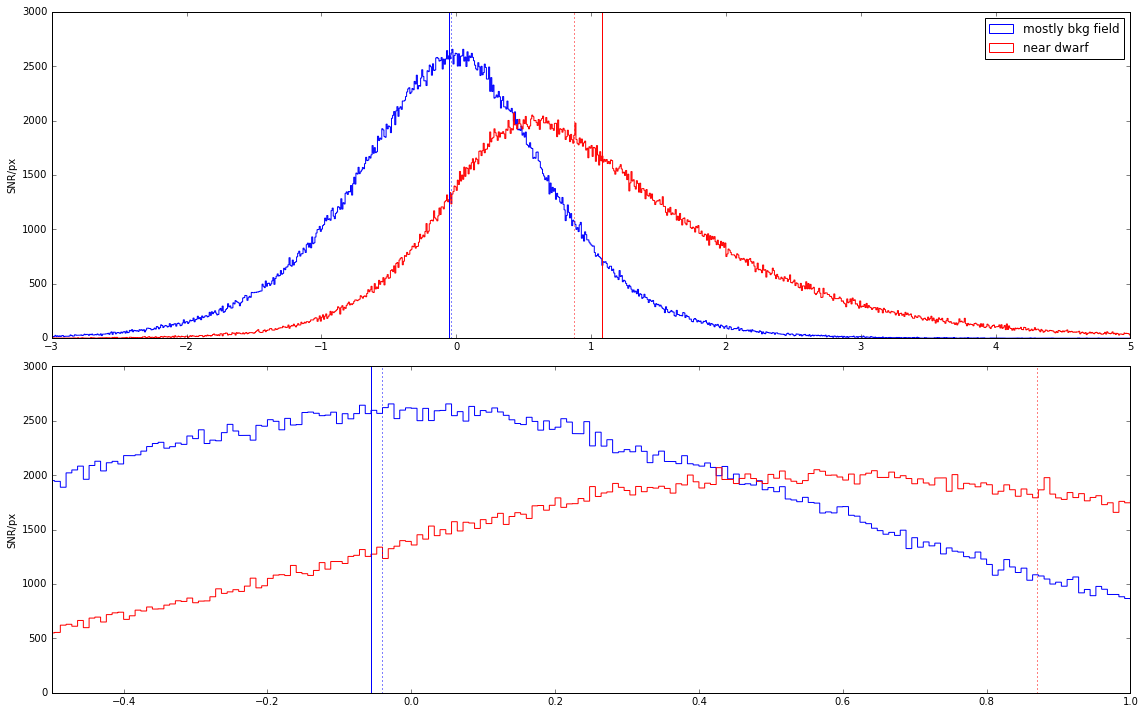

In [355]:
def mskdat(dat):
    msk = dat!=0
    return dat[msk]

pisc_b_snr_bkg = pisc_b_real_sci_bkg*pisc_b_real_wht_bkg**0.5
pisc_b_snr_near = pisc_b_real_sci_near*pisc_b_real_wht_near**0.5

def plots():
    bins = 1000
    hkwargs = dict(histtype='step', log=False, range=(-3,5))
    
    ns, bins = ahist(mskdat(pisc_b_snr_bkg), color='b', bins=bins, label='mostly bkg field', **hkwargs)[:2]
    ahist(mskdat(pisc_b_snr_near), color='r',bins=bins, label='near dwarf', **hkwargs)
    
    plt.axvline(np.mean(mskdat(pisc_b_snr_bkg)), color='b',ls='-')
    plt.axvline(np.median(mskdat(pisc_b_snr_bkg)), color='b',ls=':')
    plt.axvline(np.mean(mskdat(pisc_b_snr_near)), color='r',ls='-')
    plt.axvline(np.median(mskdat(pisc_b_snr_near)), color='r',ls=':')
    
    plt.ylabel('SNR/px')
    
plt.subplot(2,1,1)
plots()
plt.legend(loc=0)

plt.subplot(2,1,2)
plots()
plt.xlim(-.5,1)

plt.tight_layout()

# Now build an artificial image

## Start by loading the PSF and creating an appropriate model

In [8]:
f = fits.open('tinytim_psfs/f606w_piscB/result00.fits')
psfhead = f[0].header
psfdat = f[0].data
f.close()
psfcen = (psfdat.shape[0]//2, psfdat.shape[1]//2)  # the manual for tiny tim says this is always true
psfhead

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  122                                                  
NAXIS2  =                  122                                                  
EXTEND  =                    F                                                  
CREATED = 'Wed Mar  2 13:09:28 2016'  / Time and date file was created          
INSTRUME= 'ACS_WFC1'           / Simulated instrument                           
FOCUS   =               0.0307 / PSF RMS focus (waves @ 547 nm)                 
X_COMA  =               0.0114 / PSF RMS X-coma (waves @ 547 nm)                
Y_COMA  =               0.0046 / PSF RMS Y-coma (waves @ 547 nm)                
X_ASTIG =               0.0049 / PSF RMS 0d astig (waves @ 547 nm)              
Y_ASTIG =               0.02

-c:6: RuntimeWarning: divide by zero encountered in log10


1.0000006

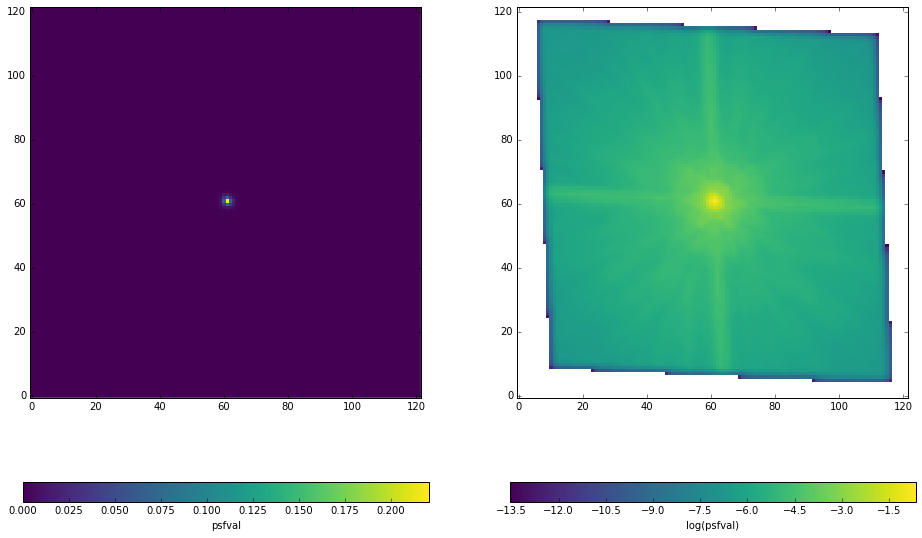

In [9]:
plt.subplot(1,2,1)
plt.imshow(psfdat)
plt.colorbar(orientation='horizontal').set_label('psfval')

plt.subplot(1,2,2)
plt.imshow(np.log10(psfdat))
plt.colorbar(orientation='horizontal').set_label('log(psfval)')

np.sum(psfdat)

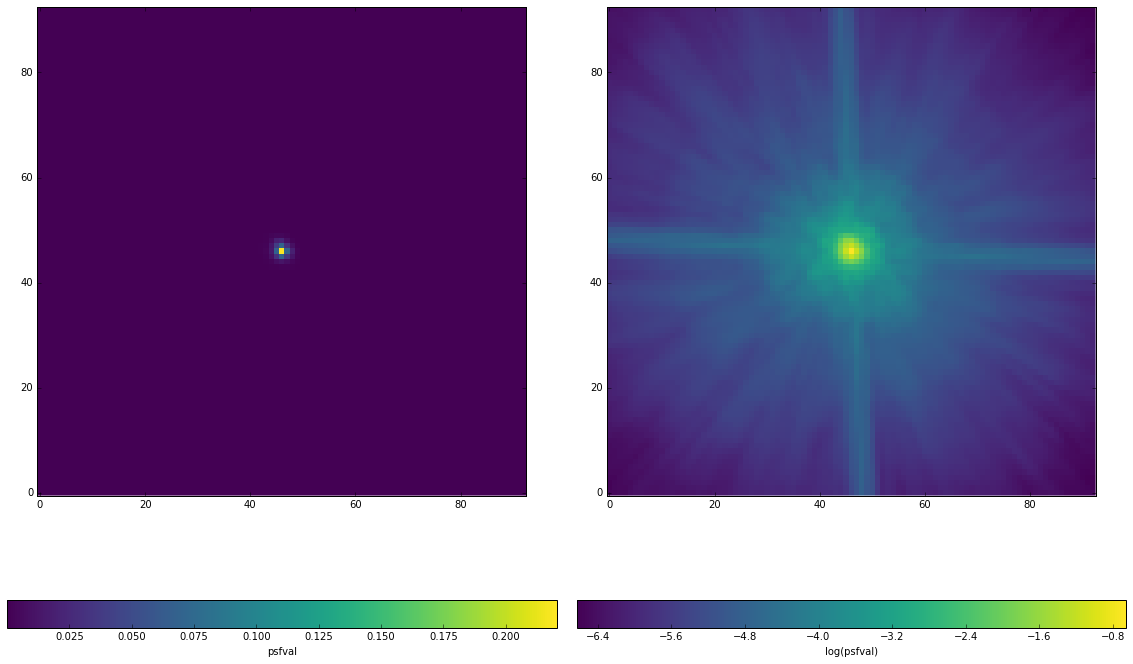

In [10]:
psf606b = PSFModel(psfdat, bbox_padding=15)

plt.subplot(1,2,1)
plt.imshow(psf606b.render())
plt.colorbar(orientation='horizontal').set_label('psfval')

plt.subplot(1,2,2)
plt.imshow(np.log10(1e-10+psf606b.render()))
plt.colorbar(orientation='horizontal').set_label('log(psfval)')
plt.tight_layout()

## Create Mock dataset comparable to pisc B

In [11]:
mock606w_shape = (680, 860)

#these are in "pixel" coordinates
mock606w_xg, mock606w_yg = np.indices(mock606w_shape)

gal_cen = [440, 340] # slightly off-center
sersic_n = 0.64
r_eff = 345.
e = 0.5
theta = 126*u.deg

## Create the profile and LF that we're going to sample from 

In [12]:
sersic = models.Sersic2D(n=sersic_n, r_eff=r_eff, ellip=e, theta=theta.to(u.radian).value, 
                         x_0=gal_cen[0], y_0=gal_cen[1])
sersic.amplitude = sersic(sersic.x_0, sersic.y_0)**-1
sersic.bounding_box = [(0, mock606w_shape[0]), (0, mock606w_shape[1])]

## Now do all the actual sampling 

-c:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


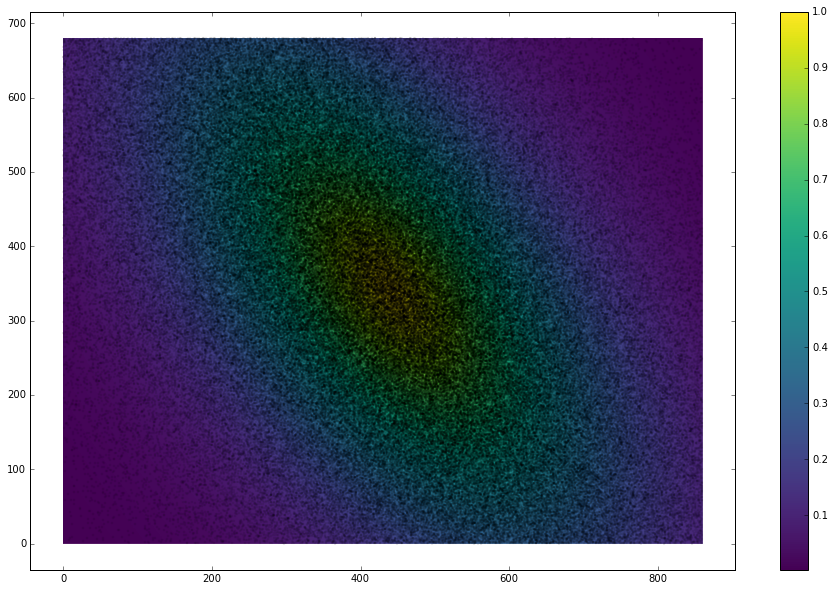

In [662]:
pts = sample_from_model(sersic, 4e5)

plt.subplot(aspect=1)
plt.imshow(sersic.render())
plt.colorbar()
plt.scatter(*pts, lw=0, s=5, c='k', alpha=.1)

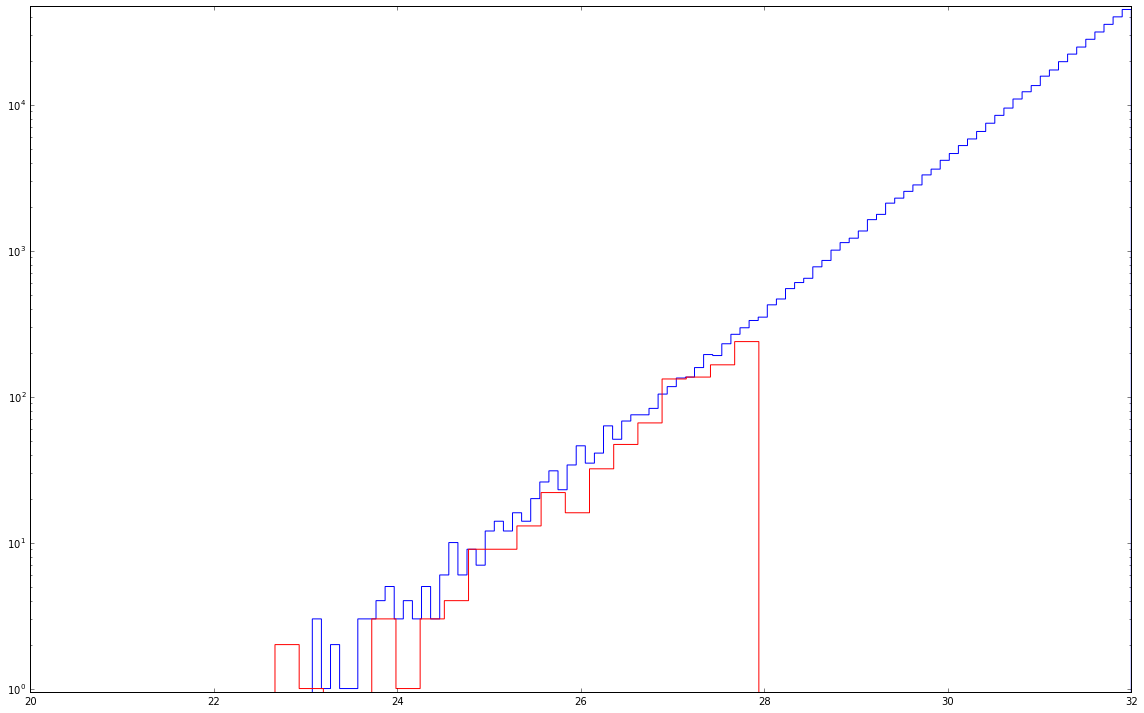

In [663]:
mags = sample_lum_func(pts.shape[1], 1.2, 23., 32)  # piscB is ~piscA+1, see above
res = ahist(mags, bins='knuth', log=True,histtype='step')
ahist(m606[msk_dwarf&sncut1]+1, bins=bins,histtype='step', color='r', log=True) # this is piscA
plt.ylim(res[0].min()*.95, res[0].max()*1.05)
plt.tight_layout()

### Now put them into the image 

In [664]:
psfmod = psf606b.copy()
mock606w = np.zeros(mock606w_shape)

st = time.time()
with ProgressBar(len(mags), 'grr') as bar:
    for i, (x, y, f) in enumerate(zip(pts[0], pts[1], 10**(mags/-2.5))):
        if i%100==0:
            secsper = (time.time() - st)/(i+1)
            secsleft = (len(mags) - i - 1)*secsper
            print('\r{:.1f} min left'.format(secsleft/60), end='')
            sys.stdout.flush()
        psfmod.x_0 = x
        psfmod.y_0 = y
        psfmod.flux = f

        psfmod.render(mock606w)
        bar.update()

#resale so that the total flux is 1
mock606w = mock606w/np.sum(mock606w)

et = time.time()
print('\rTotal time:', (et-st)/60., 'min')

0.0 min left
Total time: 23.4970674197 min


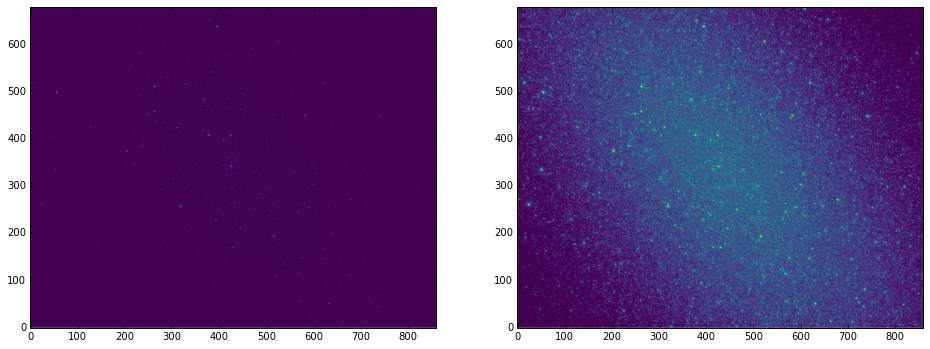

In [665]:
plt.subplot(1,2,1)
plt.imshow(mock606w)

plt.subplot(1,2,2)

plt.imshow(alllogstretch(mock606w))

In [13]:
# uncomment this to save the above version
#np.save('mock606w', mock606w)

# uncomment this to recover the last result instead of re-calculating
#mock606w = np.load('mock606w.npy')

### Poisson-ify

In [14]:
#bkg_var derived above from piscB images- note that it's per pixel, though, and the below are whole-image
gal_flux = 6000 # approximates piscB image
bkg_flux = 10000

mock606w_rate = gal_flux*mock606w/np.sum(mock606w) + bkg_flux/mock606w.size
poisson_factor = 1000

mock606w_p = np.random.poisson(mock606w_rate*poisson_factor)/poisson_factor
mock606w_psub = mock606w_p - bkg_flux/mock606w.size

mock606w_ivar = 1/mock606w_p

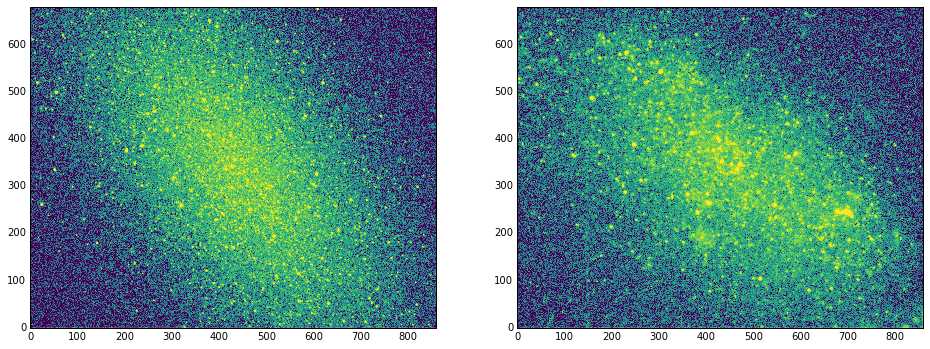

In [18]:
stretch = visualization.ManualInterval(-.1,.6) + visualization.LogStretch()

plt.subplot(1,2,1)
plt.imshow(stretch(mock606w_psub))

plt.subplot(1,2,2)
plt.imshow(stretch(pisc_b_real_sci_near))

# Now fit using the emceemr machinery

In [752]:
priors606b = dict(flux=priors.NormalPrior(6000,1000,lower=1000,upper=10000), 
              n=priors.UniformPrior(0.2,1.5),
              reffmaj=priors.UniformPrior(150,800),
              ellipticity=priors.UniformPrior(0.25, 0.75),
              cenx=priors.UniformPrior(gal_cen[1]-50, gal_cen[1]+50),
              ceny=priors.UniformPrior(gal_cen[0]-50, gal_cen[0]+50),
              theta=priors.UniformPrior(90, 180))

mod606b = SersicModel(mock606w_xg, mock606w_yg, 
                      mock606w_psub, ivar=mock606w_ivar, 
                      priors=priors606b)

nsamp, nburnin = 1000, 2000
st = time.time()
sampler606b = mod606b.initialize_and_sample(nsamp, burnin=nburnin)
et = time.time()

print(nsamp+nburnin, 'samples took', (et-st)/60, 'min')

print(emceemr.sampler_info_string(mod606b, sampler606b))

3000 samples took 64.9487628818 min
Acors:
flux: 65.2408782249
n: 66.3164127719
reffmaj: 47.3013796933
ellipticity: 44.8247337104
cenx: 38.0319879572
ceny: 46.0566777135
theta: 49.1068840433
Acceptance Fractions:
[ 0.479,  0.463,  0.478,  0.498,  0.494,  0.495,  0.503,  0.486,  0.485,
  0.482,  0.49 ,  0.454,  0.51 ,  0.477,  0.475,  0.502,  0.5  ,  0.507,
  0.472,  0.468,  0.492,  0.476,  0.479,  0.488,  0.484,  0.511,  0.487,
  0.497]


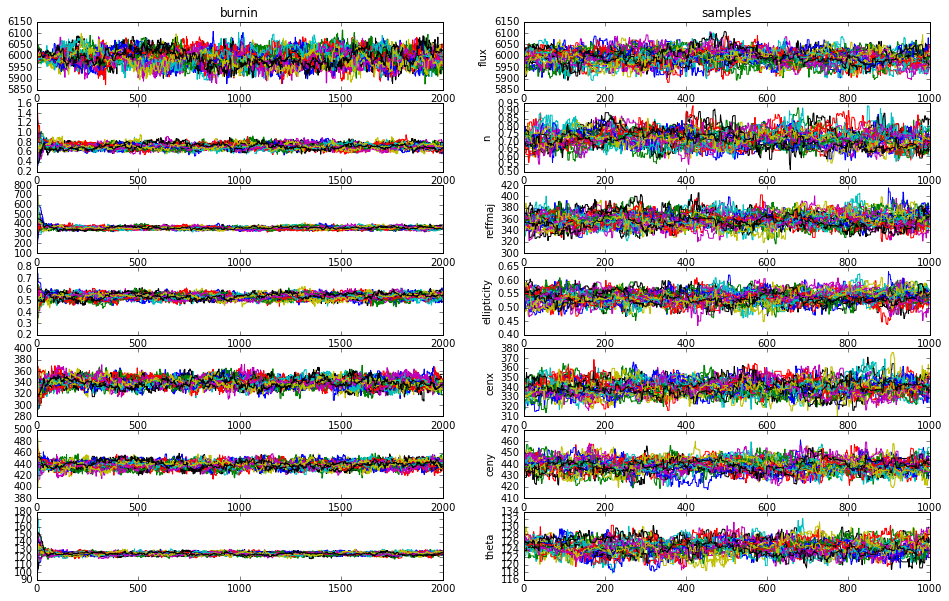

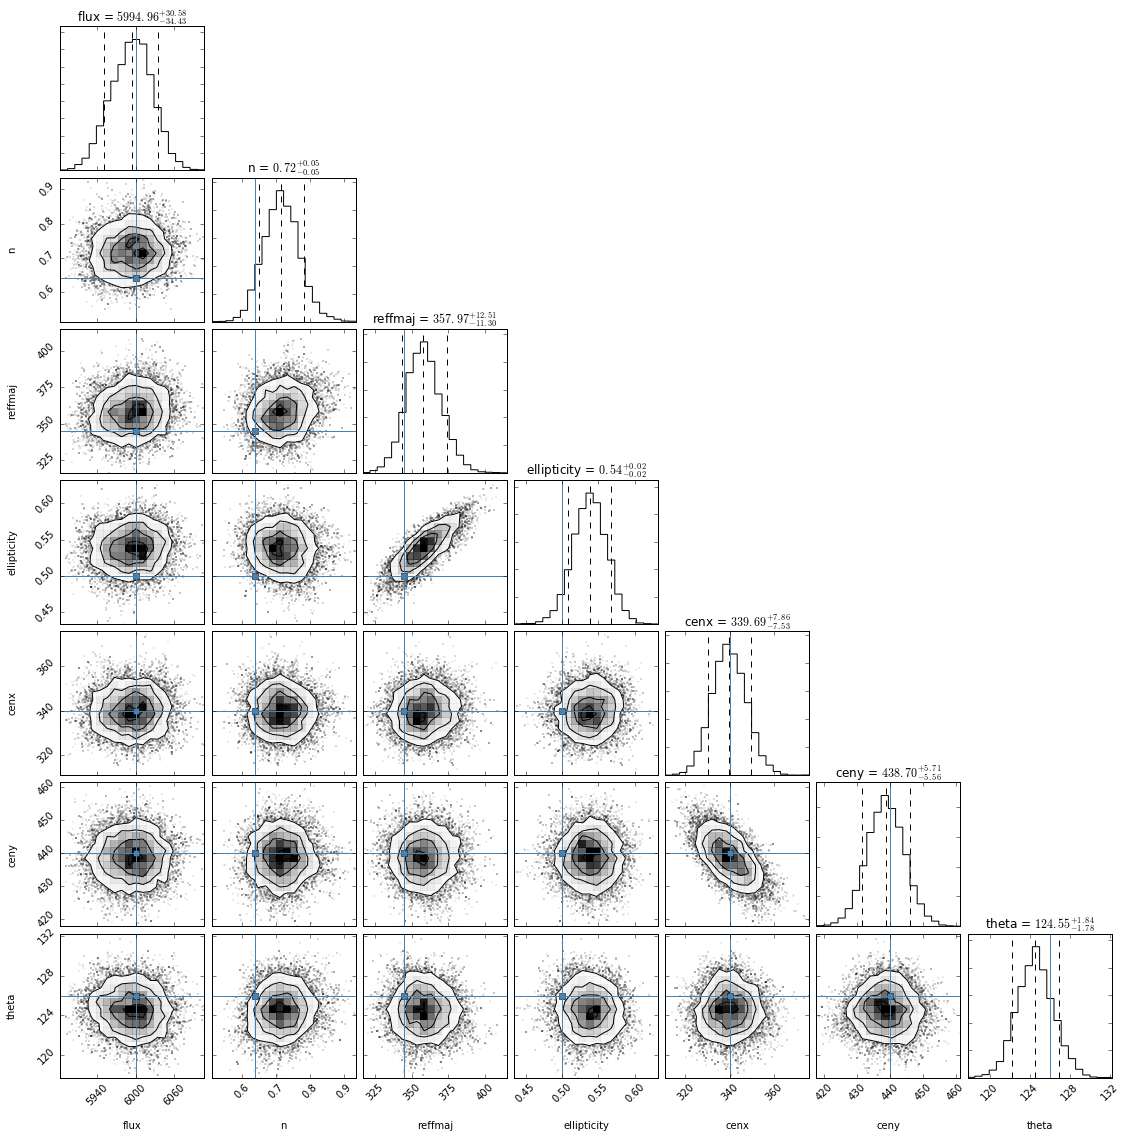

In [753]:
plt.figure()
emceemr.plot_chains(mod606b, sampler606b)

plt.figure()
emceemr.triangle_plot(mod606b, sampler606b, quantiles=[.1,.5,.9], show_titles=True, verbose=False, 
                     truths=[gal_flux, sersic_n, r_eff, e, gal_cen[1], gal_cen[0], theta.value])

OrderedDict([('flux', 5994.9556549430899), ('n', 0.71628614771311261), ('reffmaj', 357.97247323943697), ('ellipticity', 0.53837069267099247), ('cenx', 339.68558525854581), ('ceny', 438.6977701798728), ('theta', 124.55039800714398)])


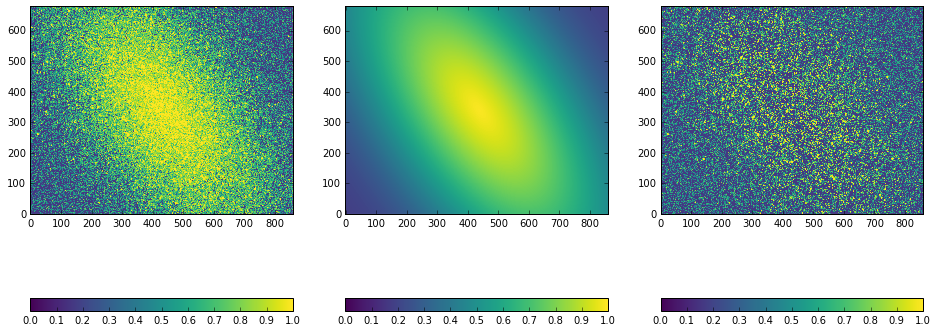

In [754]:
modparams = np.percentile(sampler606b.flatchain, 50, axis=0)
print(OrderedDict(zip(mod606b.param_names, modparams)))

ellargs = [(modparams[-3], modparams[-2]), 2*modparams[2], 2*modparams[2]*(1 - modparams[3])]
ellkwargs = dict(angle=90 - modparams[-1], facecolor='none', lw=2, edgecolor='r')

stretch = visualization.ManualInterval(-.1,.5) + visualization.LogStretch()

plt.subplot(1,3,1)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,2)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mod606b.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,3)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub-mod606b.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

## An experiment: try again but with "fake" ivars similar to what the real data have 

In [755]:
#5e-5 is the var level in the PiscB drizzled image
mock606w_ivar_rescaled = 1/(5e-5*mock606w_p/np.mean(mock606w_p))

In [756]:
mod606b_2 = SersicModel(mock606w_xg, mock606w_yg, 
                      mock606w_psub, ivar=mock606w_ivar_rescaled, 
                      priors=priors606b)

nsamp, nburnin = 1000, 2000
st = time.time()
sampler606b_2 = mod606b_2.initialize_and_sample(nsamp, burnin=nburnin)
et = time.time()

print(nsamp+nburnin, 'samples took', (et-st)/60, 'min')

print(emceemr.sampler_info_string(mod606b_2, sampler606b_2))

3000 samples took 63.6902770996 min
Acors:
flux: 50.2543319961
n: 44.1572415213
reffmaj: 46.5658630974
ellipticity: 56.9763059799
cenx: 47.979363955
ceny: 42.5479443058
theta: 53.9263713584
Acceptance Fractions:
[ 0.485,  0.444,  0.478,  0.48 ,  0.497,  0.486,  0.446,  0.499,  0.501,
  0.473,  0.463,  0.505,  0.496,  0.465,  0.506,  0.485,  0.465,  0.512,
  0.468,  0.482,  0.493,  0.487,  0.479,  0.494,  0.463,  0.508,  0.492,
  0.486]


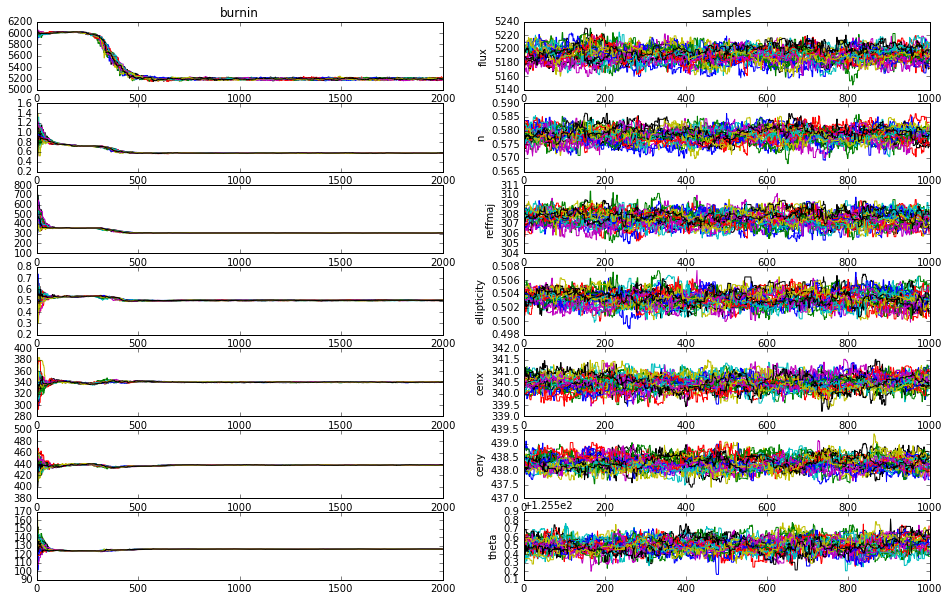

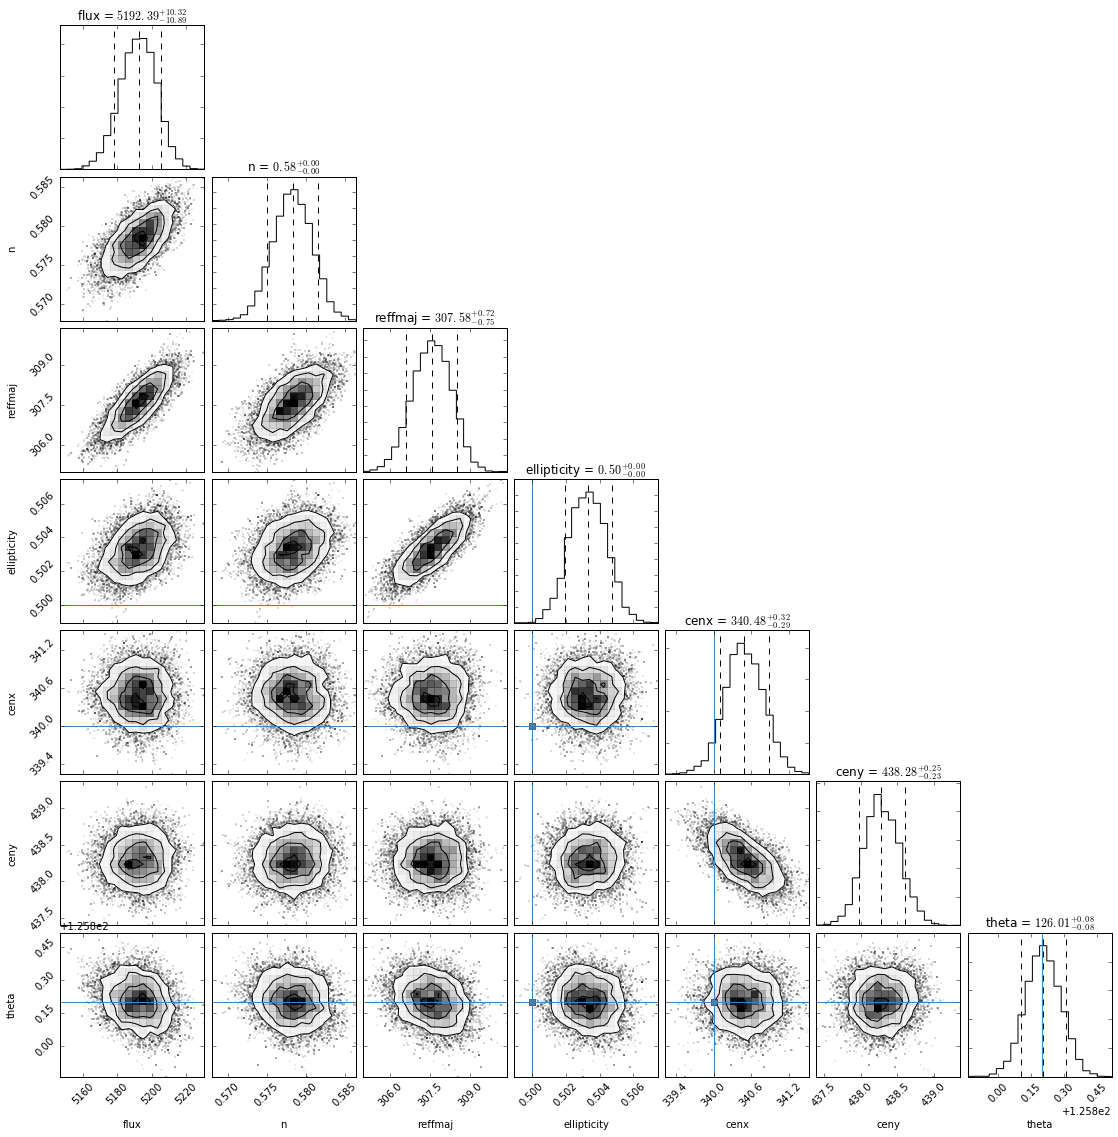

In [757]:
plt.figure()
emceemr.plot_chains(mod606b_2, sampler606b_2)

plt.figure()
emceemr.triangle_plot(mod606b_2, sampler606b_2, quantiles=[.1,.5,.9], show_titles=True, verbose=False, 
                     truths=[gal_flux, sersic_n, r_eff, e, gal_cen[1], gal_cen[0], theta.value])

OrderedDict([('flux', 5192.3867646950839), ('n', 0.57832203609392552), ('reffmaj', 307.57943713656374), ('ellipticity', 0.50331214067399244), ('cenx', 340.48272210309227), ('ceny', 438.2809244607941), ('theta', 126.00594366600889)])


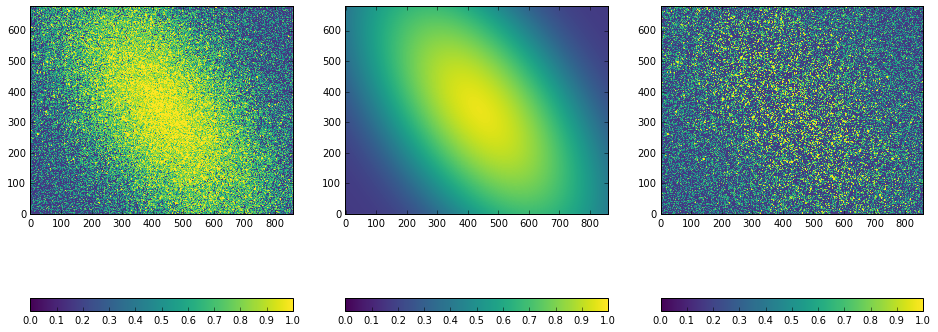

In [758]:
modparams = np.percentile(sampler606b_2.flatchain, 50, axis=0)
print(OrderedDict(zip(mod606b_2.param_names, modparams)))

ellargs = [(modparams[-3], modparams[-2]), 2*modparams[2], 2*modparams[2]*(1 - modparams[3])]
ellkwargs = dict(angle=90 - modparams[-1], facecolor='none', lw=2, edgecolor='r')

stretch = visualization.ManualInterval(-.1,.5) + visualization.LogStretch()

plt.subplot(1,3,1)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,2)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mod606b_2.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,3)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub-mod606b_2.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

# Methodology/functional tests 

## Check that the sampling method actually gets samples that match the model expectation 

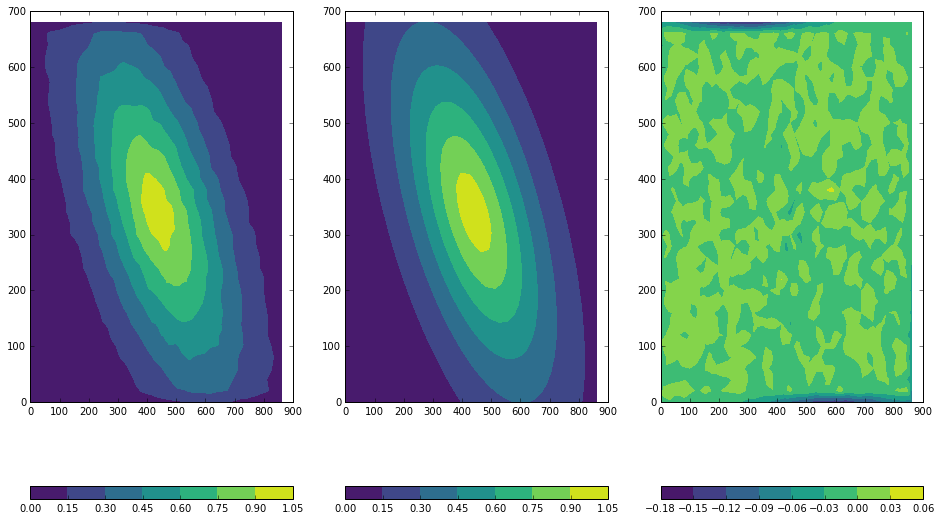

In [14]:
pts = sample_from_model(sersic, 1000000)
res = plt.hexbin(*pts, gridsize=30)
locs = res.get_offsets()
ns = res.get_array()
ns = ns/ns.max()

plt.clf()
plt.subplot(1,3,1)
plt.tricontourf(locs[:, 0], locs[:, 1], ns)
plt.colorbar(orientation='horizontal')

plt.subplot(1,3,2)
plt.tricontourf(locs[:, 0], locs[:, 1], sersic(*locs.T))
plt.colorbar(orientation='horizontal')

plt.subplot(1,3,3)
plt.tricontourf(locs[:, 0], locs[:, 1], ns-sersic(*locs.T))
plt.colorbar(orientation='horizontal')

## Check that a single PSF star goes to the right place

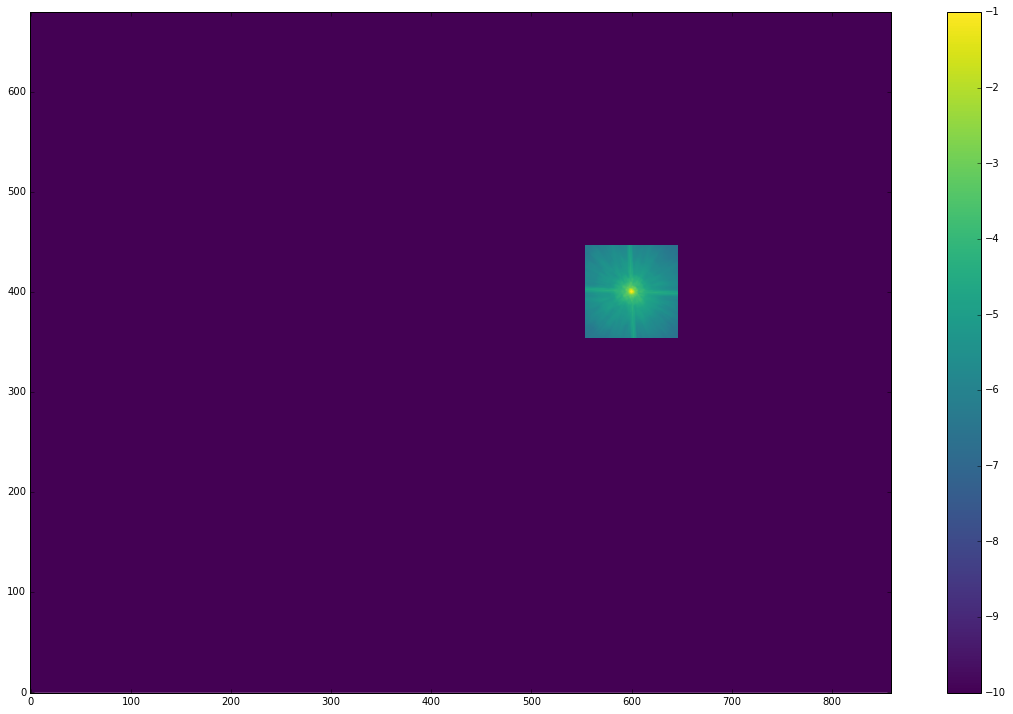

In [101]:
psf606b.x_0 = 600
psf606b.y_0 = 400
del psf606b.bounding_box

plt.imshow(np.log10(1e-10+psf606b.render(coords=(mock606w_xg, mock606w_yg))),vmin=-10,vmax=-1)
plt.colorbar(orientation='vertical')
plt.tight_layout()

# TEST 

In [19]:
priors606b = dict(flux=priors.NormalPrior(6000,1000,lower=1000,upper=10000), 
              n=priors.UniformPrior(0.2,1.5),
              reffmaj=priors.UniformPrior(150,800),
              ellipticity=priors.UniformPrior(0.25, 0.75),
              cenx=priors.UniformPrior(gal_cen[1]-50, gal_cen[1]+50),
              ceny=priors.UniformPrior(gal_cen[0]-50, gal_cen[0]+50),
              theta=priors.UniformPrior(90, 180))

mod606b = SersicModel(mock606w_xg, mock606w_yg, 
                      mock606w_psub, ivar=mock606w_ivar, 
                      priors=priors606b)

nsamp, nburnin = 1000, 2000
st = time.time()
sampler606b = mod606b.initialize_and_sample(nsamp, burnin=nburnin)
et = time.time()

print(nsamp+nburnin, 'samples took', (et-st)/60, 'min')

print(emceemr.sampler_info_string(mod606b, sampler606b))

3000 samples took 67.2692365328 min
Acors:
flux: 46.1250062753
n: 45.6737873637
reffmaj: 42.9219947276
ellipticity: 52.1472184384
cenx: 53.6245732499
ceny: 53.8119326633
theta: 44.378210665
Acceptance Fractions:
[ 0.484,  0.495,  0.483,  0.489,  0.462,  0.481,  0.492,  0.455,  0.501,
  0.459,  0.48 ,  0.473,  0.489,  0.491,  0.469,  0.499,  0.488,  0.498,
  0.469,  0.451,  0.478,  0.462,  0.473,  0.479,  0.489,  0.446,  0.481,
  0.5  ]


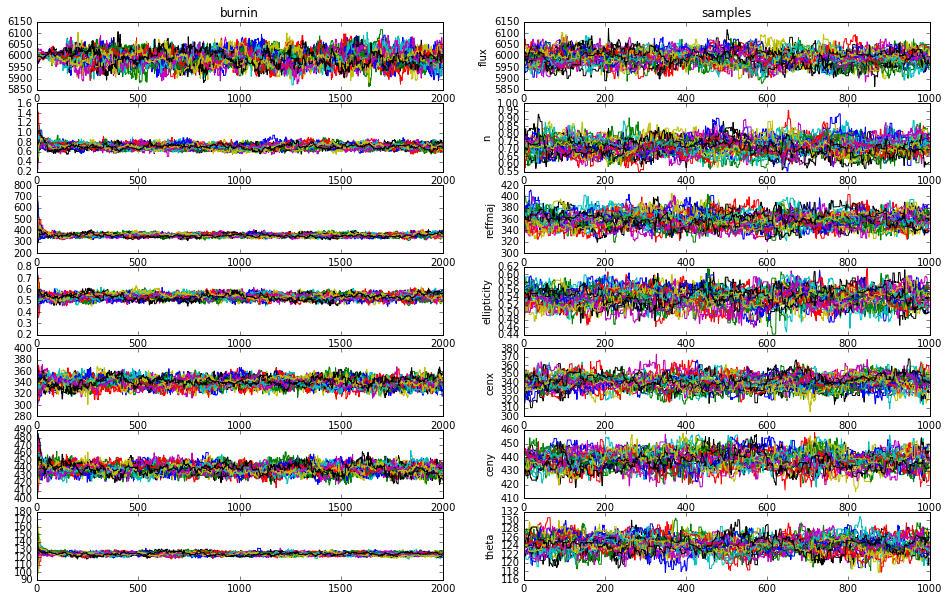

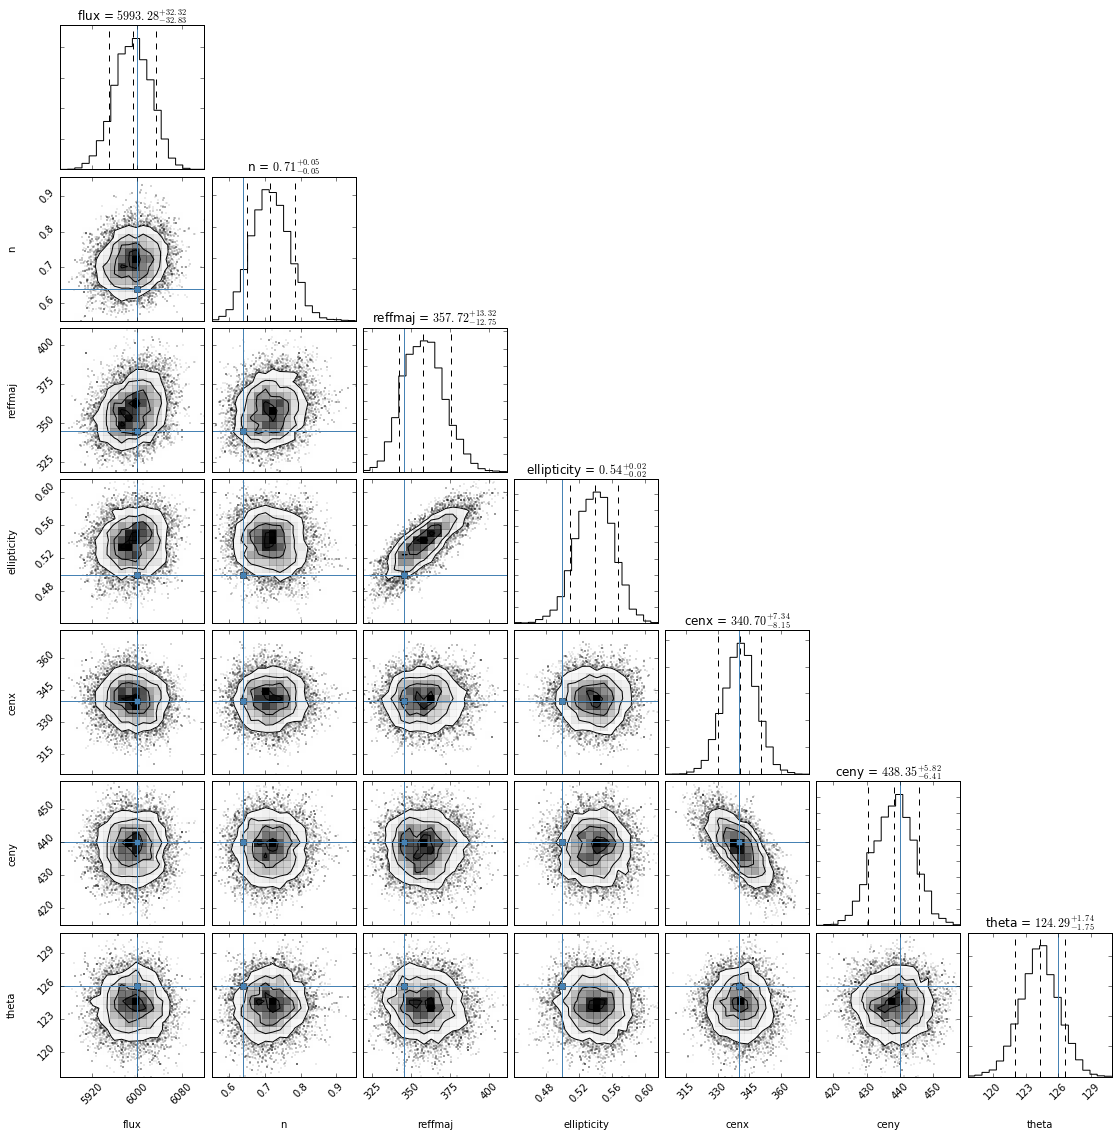

In [20]:
plt.figure()
emceemr.plot_chains(mod606b, sampler606b)

plt.figure()
emceemr.triangle_plot(mod606b, sampler606b, quantiles=[.1,.5,.9], show_titles=True, verbose=False, 
                     truths=[gal_flux, sersic_n, r_eff, e, gal_cen[1], gal_cen[0], theta.value])

OrderedDict([('flux', 5993.2834560301817), ('n', 0.71474081909169684), ('reffmaj', 357.71590397299138), ('ellipticity', 0.5393367849638232), ('cenx', 340.69882820875421), ('ceny', 438.34622067557405), ('theta', 124.29046546527536)])


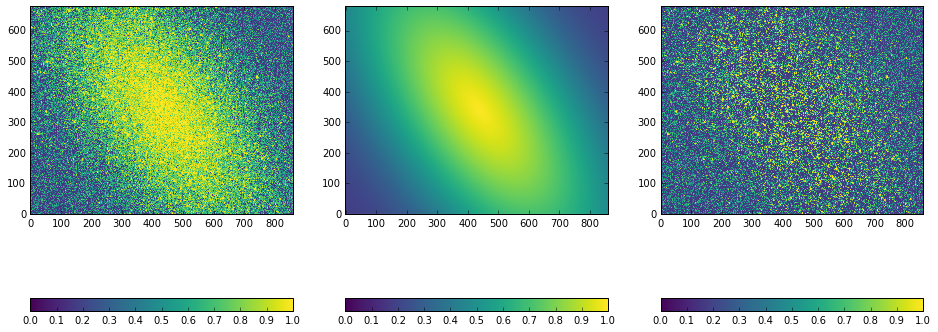

In [21]:
modparams = np.percentile(sampler606b.flatchain, 50, axis=0)
print(OrderedDict(zip(mod606b.param_names, modparams)))

ellargs = [(modparams[-3], modparams[-2]), 2*modparams[2], 2*modparams[2]*(1 - modparams[3])]
ellkwargs = dict(angle=90 - modparams[-1], facecolor='none', lw=2, edgecolor='r')

stretch = visualization.ManualInterval(-.1,.5) + visualization.LogStretch()

plt.subplot(1,3,1)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,2)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mod606b.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,3,3)#.add_patch(patches.Ellipse(*ellargs, **ellkwargs))
plt.imshow(stretch(mock606w_psub-mod606b.get_model(*modparams)),vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')